In [1]:
! nvidia-smi

Thu Dec 10 16:23:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install gpytorch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


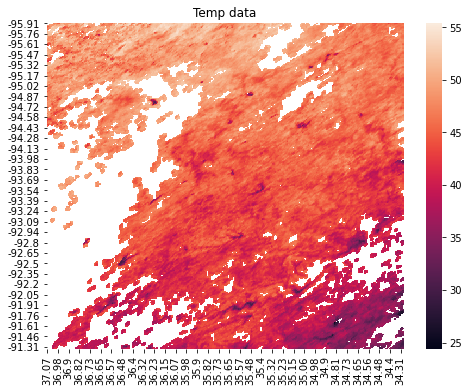

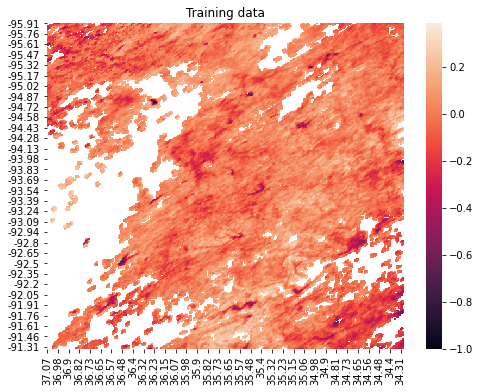

Iter 1/20 - Loss: 0.929
Iter 2/20 - Loss: -0.025
Iter 3/20 - Loss: 0.568
Iter 4/20 - Loss: -0.260
Iter 5/20 - Loss: -0.433
Iter 6/20 - Loss: -0.521
Iter 7/20 - Loss: -0.452
Iter 8/20 - Loss: -0.397
Iter 9/20 - Loss: -0.480
Iter 10/20 - Loss: -0.564
Iter 11/20 - Loss: -0.604
Iter 12/20 - Loss: -0.616
Iter 13/20 - Loss: -0.645
Iter 14/20 - Loss: -0.671
Iter 15/20 - Loss: -0.718
Iter 16/20 - Loss: -0.675
Iter 17/20 - Loss: -0.440
Iter 18/20 - Loss: -0.500
Iter 19/20 - Loss: -0.474
Iter 20/20 - Loss: -0.653


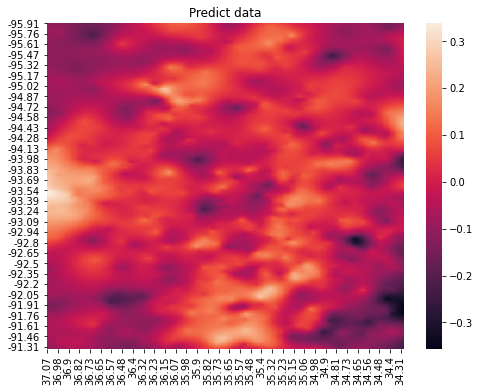

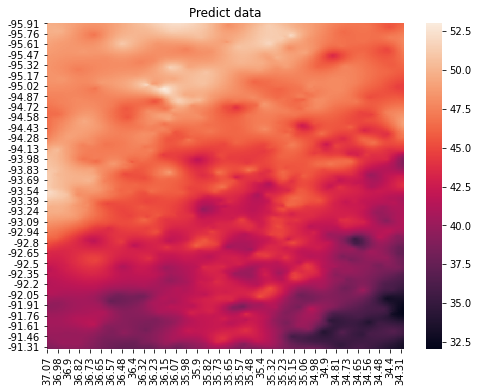

In [4]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import gpytorch
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from torch.utils.data import TensorDataset, DataLoader
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = pd.read_csv('/content/drive/My Drive/data/all_sat_temp.csv').iloc[:,1:]
#data = pd.read_csv('/content/drive/My Drive/data/all_sim_temp.csv').iloc[:,1:]
lon = np.array(data['Lon']).reshape(300,500).T
lat = np.array(data['Lat']).reshape(300,500).T
temps = np.array(data['MaskTemp']).reshape(300,500).T

temps_real = np.array(data['TrueTemp']).reshape(300,500).T

#lon = lon[:150,:200]
#lat = lat[:150,:200]
#temps = temps[:150,:200]
#temps_1 = temps
#temps_real = temps_real[:150,:200]

plt.figure(figsize=(8,6))
plot_df = pd.DataFrame(temps,index=np.round(lon[:,0],2),columns = np.round(lat[0,:],2))
sns.heatmap(plot_df)
plt.title('Temp data')
plt.show()
plt.close()

# make sure that longtitude row vector are the same
# latitude column vector remains the same
# maybe not true temp
# use ~ to invert logical array

# the normalized scale seems to cause problem:
# NaNs encountered when trying to perform matrix-vector multiplication

# swich back to 0-1 scale
mask = ~np.isnan(temps)
mask_nan = np.isnan(temps)
df = pd.DataFrame({'y':temps[mask],'lon':lon[mask],'lat':lat[mask]})
linear = linear_model.LinearRegression().fit(df[['lon','lat']],df['y'])
temps_pred = linear.intercept_ + linear.coef_[0]*lon + linear.coef_[1]*lat
temps = temps - temps_pred
maxtemp = np.nanmax(abs(temps))
#maxtemp = np.nanmax(temps)
#mintemp = np.nanmin(temps)
#temps = (temps-mintemp)/(maxtemp-mintemp)
temps = temps/(maxtemp)
plt.figure(figsize=(8,6))
plot_df = pd.DataFrame(temps,index=np.round(lon[:,0],2),columns = np.round(lat[0,:],2))
sns.heatmap(plot_df)
plt.title('Training data')
plt.show()
plt.close()
# now we start with a square grid

grid1 = lon[:,0]
grid2 = lat[0,:]
grid1 = torch.from_numpy(grid1)
grid2 = torch.from_numpy(grid2)

class Variation_GP(ApproximateGP):
        def __init__(self,inducing_points):
            variational_dist = CholeskyVariationalDistribution(inducing_points.size(0))
            variational_strat = VariationalStrategy(self,inducing_points,variational_dist, learn_inducing_locations=True)
            super().__init__(variational_strat)
            self.mean_module = gpytorch.means.ConstantMean()
            """
            self.covar_module = gpytorch.kernels.ScaleKernel(#gpytorch.kernels.MaternKernel()
                gpytorch.kernels.SpectralMixtureKernel(2,ard_num_dims=2)
                                                             )
                                                             """
            self.covar_module =  gpytorch.kernels.GridKernel(gpytorch.kernels.MaternKernel(nu=0.5),grid=[grid1,grid2])  
            #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))                                    
        def forward(self,x):
            mean_x = self.mean_module(x).view(1,-1)
            covar_x = self.covar_module(x)
            output = gpytorch.distributions.MultitaskMultivariateNormal(mean_x,covar_x)
            return output 

train_x = np.c_[lon[mask].reshape(-1,1),lat[mask].reshape(-1,1)]
train_y = temps[mask]
train_x = torch.from_numpy(train_x).double()
train_y = torch.from_numpy(train_y).double()

#train_y = train_y.view(-1)


#index_refer = np.random.choice(np.arange(0,train_x.size(0)),3000)
index_refer = np.random.choice(np.arange(0,train_x.size(0)),3300)
inducing_points = train_x[index_refer,:]
model = Variation_GP(inducing_points).double()
likelihood = gpytorch.likelihoods.GaussianLikelihood()

likelihood = likelihood.cuda()
model = model.cuda()


model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.1)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

train_x = train_x.cuda()
train_y = train_y.cuda()

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=4000, shuffle=True)

train_iter = 20

start_time = time.time()
for i in range(train_iter):
    for x_bat, y_bat in train_loader:
        #x_bat = x_bat
        #y_bat = y_bat
        optimizer.zero_grad()
        output = model(x_bat)
        loss = -mll(output, y_bat)
        loss.backward()
        optimizer.step()
    print("Iter %d/%d - Loss: %.3f" % (
    i + 1, train_iter, loss.item()
))
    
model.eval()
likelihood.eval()

test_x = np.c_[lon.reshape(-1,1),lat.reshape(-1,1)]
test_x = torch.from_numpy(test_x).double()
test_x = test_x.cuda()
means = torch.tensor([0.])
test_y = np.zeros((test_x.size(0),1))
test_y = torch.from_numpy(test_y).double()


test_loader = TensorDataset(test_x,test_y)
test_loader = DataLoader(test_loader,batch_size = 1000,shuffle=False)



"""
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
"""

vars = torch.tensor([0.])
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for test_batch,y_batch_ in test_loader:
        preds = model(test_batch)
        means = torch.cat([means, preds.mean.cpu().view(-1)])
        vars = torch.cat([vars,preds.variance.cpu().view(-1)])

end_time =  time.time()

#pred_labels = observed_pred.mean.view(50, 100)
#pred_labels = pred_labels.cpu().numpy()
pred_labels = means[1:].numpy().reshape(lon.shape[0],lon.shape[1])
plt.figure(figsize=(8,6))
plot_df = pd.DataFrame(pred_labels,index=np.round(lon[:,0],2),columns = np.round(lat[0,:],2))
sns.heatmap(plot_df)
plt.title('Predict data')
plt.show()
plt.close()

pred_labels = pred_labels * maxtemp

final_temps = (linear.intercept_ + linear.coef_[0]*lon + linear.coef_[1]*lat)+pred_labels

plt.figure(figsize=(8,6))
plot_df = pd.DataFrame(final_temps,index=np.round(lon[:,0],2),columns = np.round(lat[0,:],2))
sns.heatmap(plot_df)
plt.title('Predict data')
plt.show()
plt.close()

In [5]:
print(f'the running time is:{(end_time-start_time)/60} minutes')

the running time is:53.337993888060254 minutes


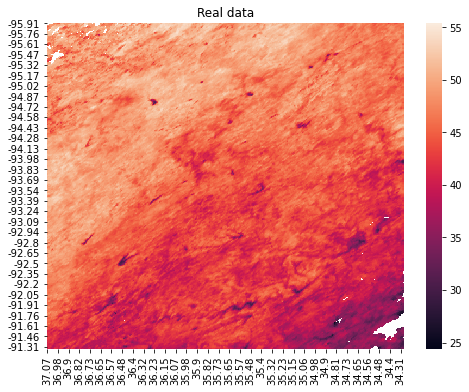

In [6]:
data = pd.read_csv('/content/drive/My Drive/data/all_sat_temp.csv').iloc[:,1:]
lon = np.array(data['Lon']).reshape(300,500).T
lat = np.array(data['Lat']).reshape(300,500).T
temps = np.array(data['MaskTemp']).reshape(300,500).T

temps_real = np.array(data['TrueTemp']).reshape(300,500).T


plt.figure(figsize=(8,6))
plot_df = pd.DataFrame(temps_real,index=np.round(lon[:,0],2),columns = np.round(lat[0,:],2))
sns.heatmap(plot_df)
plt.title('Real data')
plt.show()
plt.close()

In [7]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
final_temps = final_temps.reshape(-1)
temps_real = temps_real.reshape(-1)
number_index = ~np.isnan(temps_real)
number_index = np.array([a and b for a,b in zip(number_index,mask_nan.reshape(-1))])
vars_true = vars[1:].numpy()

In [8]:
#( ~np.isnan(temps_real)).shape

In [9]:
final_temps_1 = final_temps[number_index]
temps_real_1 = temps_real[number_index]
vars_true = vars_true[number_index]

In [10]:
mse_error = mean_squared_error(final_temps_1.reshape(-1),temps_real_1.reshape(-1))
RMSE = np.sqrt(mse_error)
MAE = mean_absolute_error(final_temps_1.reshape(-1),temps_real_1.reshape(-1))
from scipy.stats import norm





def CRPS(predict,original,net_output):
    sd = np.sqrt(net_output) * maxtemp
    Z = (original-predict)/sd
    scores = sd* (Z *(2 * norm.cdf(Z) - 1) + 2 * norm.pdf(Z) - 1/np.sqrt(np.pi))	
    output = np.mean(scores)
    return output

CPRS_score = CRPS(final_temps_1.reshape(-1),temps_real_1.reshape(-1),vars_true)


def INT(predict,original,net_output,alpha):
    sd = np.sqrt(net_output) * maxtemp
    hw = -norm.ppf(alpha/2) * sd
    scores = 2 * hw + (2/alpha) * (((predict - hw) - original) * (original < (predict - hw)) +
                                    (original - (predict + hw)) * (original > (predict + hw)))
    output = np.mean(scores)
    return output

INT_score = INT(final_temps_1.reshape(-1),temps_real_1.reshape(-1),vars_true,0.05)

def CVG(predict,original,net_output,alpha):
    sd = np.sqrt(net_output) * maxtemp
    hw = -norm.ppf(alpha/2) * sd
    scores = ((predict - hw) <= original) & (original <= (predict + hw))
    output = np.mean(scores)
    return(output)
CVG_score = CVG(final_temps_1.reshape(-1),temps_real_1.reshape(-1),vars_true,0.05)

MAE = pd.Series(MAE)
RMSE = pd.Series(RMSE)
CPRS_score = pd.Series(CPRS_score)
INT_score = pd.Series(INT_score)
CVG_score = pd.Series(CVG_score)
score_compare = pd.DataFrame({'MAE':MAE,'RMSE':RMSE,'CPRS':CPRS_score,'INT':INT_score,'CVG':CVG_score})


print(score_compare.round(2).to_latex(index=False))
print(end_time-start_time)

\begin{tabular}{rrrrr}
\toprule
  MAE &  RMSE &  CPRS &    INT &   CVG \\
\midrule
 2.12 &   2.6 &  1.54 &  15.14 &  0.85 \\
\bottomrule
\end{tabular}

3200.279633283615


In [11]:
print(score_compare.round(2).to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
  MAE &  RMSE &  CPRS &    INT &   CVG \\
\midrule
 2.12 &   2.6 &  1.54 &  15.14 &  0.85 \\
\bottomrule
\end{tabular}

